## About this tutorial 

In my post about [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/), you have seen that [scikit-learn](https://scikit-learn.org) makes it easy to train a simple neural network. 

scikit-learn focuses on providing a unified interface for training and testing many machine learning algorithms: neural networks, support-vector machines, naive Bayes, nearest neighbours, decision trees, etc. 

However, scikit-learn has three major drawbacks when it comes to neural networks specifically: 

* the interface does not provide enough control to build complex neural networks
* a lot of magic happens under the hood, like regularization
* it's not adapted to [deep learning](https://thedatafrog.com/install-tensorflow-windows/)

In this post, we will repeat our exercise about handwritten digit recognition with [Keras](https://keras.io/), a high-level neural networks API. You will learn how to: 

* Create a simple dense neural network with Keras
* Estimate its performance 

Later on, we will use Keras as an interface to TensorFlow to do deep learning. 

**Prerequisites:** You have completed [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/).


## Preparing the dataset 

As in [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/), we are going to use the digits dataset provided by scikit-learn. The digits are 8x8 images that are fed into a neural network with:

* an input layer with 8x8 = 64 neurons
* a hidden layer with 15 neurons
* an output layer with 10 neurons corresponding to the 10 digit categories. 

First, let's initialize our tools and load the digits dataset: 

In [46]:
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True' # needed to run on mac os 

from sklearn import datasets
digits = datasets.load_digits()

The input layer requires a 1-dimensional array in input, but our images are 2D. So we need to flatten all images:

In [47]:
x = digits.images.reshape((len(digits.images), -1))
x.shape

(1797, 64)

The targets require a bit of attention. At the moment, `digits.target` contains the digit corresponding to each image in the dataset: 

In [48]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

But in Keras, we have to build our neural network with 10 output neurons (this actually happens under the hood by scikit-learn). During the training, Keras will have to compare the 10 output values of these neurons to the target value. But how can we compare a vector of 10 values with a single target value? 

The solution is to translate each target value into a vector of length 10 with a technique called *one-hot encoding*: 

* target `0` is translated to `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* target `1` is translated to `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* target `9` is translated to `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

After doing that, the values from the output neurons, which are probabilities ranging from 0 to 1, can be compared directly to the values in the target vector. In this way, for a given number, say 0, the neural network can be trained to output a high probability from the first output neuron, and a low probability from the following neurons.  

One-hot encoding can be performed easily with the utilities provided by Keras: 

In [44]:
from keras.utils import np_utils
y = np_utils.to_categorical(digits.target,10)
print digits.target
print y

[0 1 2 ... 8 9 8]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


let's now split our data into a training sample and a testing sample:

In [45]:
split_limit=1000
x_train = x[:split_limit]
y_train = y[:split_limit]
x_test = x[split_limit:]
y_test = y[split_limit:]

The first 1000 images and labels are going to be used for training. The rest of the dataset will be used later to test the performance of our network. 

We can now create the neural network. We use one hidden layers with 15 neurons. The output layer must have exactly 10 neurons because we want to classify our digits in 10 categories. Don't pay attention to the other parameters, we'll cover that in future posts.

In [22]:
from keras import layers, Model, optimizers, regularizers

In [37]:
# creation of the input layer: 
img_input = layers.Input(shape=(64,))

# creation of the hidden layer
tmp = layers.Dense(15, activation='sigmoid')(img_input)

# creation of the output layer
output = layers.Dense(10, activation='sigmoid')(tmp)
model = Model(img_input, output)
model.summary()

l2_rate = 1e-4
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = regularizers.l2(l2_rate)
        layer.bias_regularizer = regularizers.l2(l2_rate)
        layer.activity_regularizer = regularizers.l2(l2_rate)
        
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.1, momentum=0.9),
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                975       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                160       
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=100, epochs=50)

Train on 1000 samples, validate on 797 samples
Epoch 1/50
1000/1000 [==============================] - 0s 407us/step - loss: 2.2637 - acc: 0.2090 - val_loss: 2.1661 - val_acc: 0.3664
Epoch 2/50
1000/1000 [==============================] - 0s 26us/step - loss: 2.0716 - acc: 0.4680 - val_loss: 1.9946 - val_acc: 0.4730
Epoch 3/50
1000/1000 [==============================] - 0s 24us/step - loss: 1.8688 - acc: 0.5990 - val_loss: 1.7360 - val_acc: 0.6750
Epoch 4/50
1000/1000 [==============================] - 0s 26us/step - loss: 1.5525 - acc: 0.7790 - val_loss: 1.3903 - val_acc: 0.7754
Epoch 5/50
1000/1000 [==============================] - 0s 24us/step - loss: 1.1755 - acc: 0.8700 - val_loss: 1.0725 - val_acc: 0.8294
Epoch 6/50
1000/1000 [==============================] - 0s 26us/step - loss: 0.8660 - acc: 0.9060 - val_loss: 0.8725 - val_acc: 0.8294
Epoch 7/50
1000/1000 [==============================] - 0s 24us/step - loss: 0.6742 - acc: 0.9150 - val_loss: 0.6907 - val_acc: 0.8181
Epoch 8

In [39]:
predictions = model.predict(x_test)

prediction: 1 	true value: 1


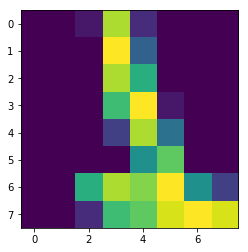

In [40]:
img = x_test[0].reshape(8,8)
plt.imshow(img)
print 'prediction:', np.argmax(predictions[0]), '\ttrue value:', np.argmax(y_test[0])

In [41]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.show()
    


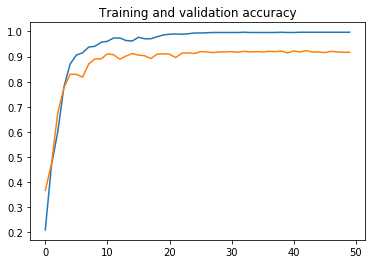

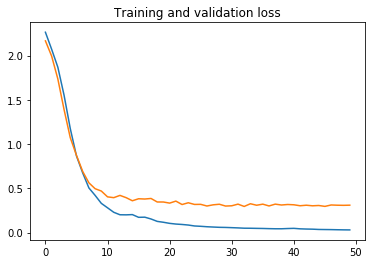

In [42]:
plot_history(history)

In [43]:
y_test_best = np.argmax(y_test,1)
predictions_best = np.argmax(predictions,1)

from sklearn.metrics import accuracy_score
accuracy_score(y_test_best, predictions_best)

0.917189460476788